<h1><center>Ageing-based 4D Face Recognition using Attention Mechanism</center></h1>

<div style="text-align: right">By:
<br>Ravi Dhir</div>

## Contents

* [1. Introduction](#1)
* [2. Setting up Environment](#2)
 * [2.1 Import Required Libraries](#2.1)
 * [2.2 Setting Hyperparameters](#2.2)
* [3. Data Preprocessing](#3)
 * [3.1 Preprocessing CACDSs](#3.1)
 * [3.3 Preprocessing Bosphorous](#3.2)
* [4. AcGAN](#4)
 * [4.1 Training AcGAN](#4.1)
 * [4.2 Testing AcGAN](#4.2)
* [5. 3DVAEGAN](#5)
 * [5.1 Training 3DVAEGAN](#5.1)
 * [5.2 Testing 3DVAEGAN](#5.2)

<a id="1"></a>
## 1. Introduction

**Human Face Detection is one of the primary areas of focus for Computer vision. We have been reaping the benefits of doing 3D face detection over 2D, as it offers many advantages like occlusion and face-reconstruction. On the other hand, we have noticed face ageing is of great importance in security and entertainment areas. Being able to detect the impact of time on a human face is of great value. In this approach, we explore the power of Generative Adversarial Networks along with attention mechanism, which caters to the most common problem of occlusion in data.**

Following repositories have been used as base code for the code:
- https://github.com/JensonZhu14/AcGAN
- https://github.com/bryonkucharski/Multiview-3D-VAE-GAN

AAdditionally, the below repositories have served as an inspiration:

- https://github.com/guyuchao/IPCGANs-Pytorch

The code is divided into two parts, where the formal uses attention mechanism based GAN (AcGAN) to understand ageing in human beings, while the latter uses the imput of generated to create 3-D models of human face.

<a id="2"></a>
## 2. Setting up Environment

The code has been implemented using below environment:
- Python 3.7.0
- PyTorch 1.4.0
- CUDA 10.1

<a id="2.1"></a>
### 2.1 Import Required Libraries

##### Import Common Libraries

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage import transform as trans
##############
import torch
import torch.utils.data as tordata
from torch import  nn
from torch import optim
from torch import multiprocessing as mp
from torch.autograd import Variable
from torch.nn import functional as F
##############
import torchvision
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from mtcnn.mtcnn import MTCNN
##############
from copy import deepcopy
import sys, time, os, random
import os.path as osp
from collections import OrderedDict
from datetime import datetime
import warnings
##############
from tqdm import tqdm,tnrange
import GPUtil
import gc
plt.switch_backend("TkAgg")
##############
from tensorboard import summary
##############
warnings.filterwarnings("ignore")

In [59]:
# For Testing Purpose
from PIL import Image
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import cv2

##### Import Helper Code

In [58]:
## Helper Code for AcGAN
#import Imports.Preprocessing.pre_cacds as pre_cacds
from Imports.Network.Acgan import Generator, Discriminator
from Imports.DataLoader.Acgan_Data_Loader import AgeDataset
import Imports.Helper.evaluator as evaluator
import Imports.Helper.ops as ops
import Imports.Model.AcGANsModel as AcGANsModel
import Imports.network
import Imports.DataLoader.DataLoader_Pretrain_Alexnet
import Imports.Model.faceAlexnet

from Imports.Model.faceAlexnet import AgeClassify
from Imports.DataLoader.DataLoader_Pretrain_Alexnet import CACD_AlexNet
##################
from Imports.DataLoader.DataLoader_IpcGans import CACD
from Imports.Model.faceAlexnet import IPCGANs

In [8]:
## Helper Code for VAEGAN
import Imports.Preprocessing.pre_bosphorous as pre_bosphorous
import Imports.Helper.util as utils
#from Imports.Helper.util import str2bool as str2bool
from Imports.Helper.util import make_hyparam_string, SavePloat_Voxels, generateZ 
from Imports.DataLoader.BosphorousDataset import BosphorousDataset
from Imports.Helper.util import var_or_cuda
from Imports.Helper.pickle_helper import save_new_pickle, read_pickle
import Imports.Helper.binvox_rw as binvox_rw
from Imports.Helper.lr_sh import  MultiStepLR
from Imports.Model.vaegan import _G, _D, _E

<a id="2.2"></a>
### 2.2 Setting Hyperparameters

In [ ]:
class Hyperparams:
    def __init__(self):
        ## Common Hyperparameters
        self.batch_size= 2
        self.max_epoch= 3000
        self.image_size= 224
        self.CUDA_VISIBLE_DEVICES = '0'


In [21]:
class Hyperparams:
    def __init__(self):
        ## Common Hyperparameters
        self.batch_size= 2
        self.max_epoch= 3000
        self.image_size= 224
        self.CUDA_VISIBLE_DEVICES = '0'
        ########################
        ## Parameters for AcGAN
        ########################
        self.age_group = 5
        self.output_dir = 'Checkpoint/Acgan/Pickle'
        self.log_dir = "Checkpoint/Acgan/Log/"
        self.dataset_name = "CACD"
        self.generate_age_list = [15,25,35,45,55]
        self.label_range = [16,62]
        self.model_name = 'AcGANs'
        self.test_size = 0.1
        self.is_ordinal_reg = False
        self.D_cond_weight= 100
        self.D_lr= 0.0001
        self.D_prob_weight= 10
        self.G_lr= 0.0001
        self.begin_save_epoch= 25
        self.gradient_penalty_weight= 10
        self.lr_decay= 0.9
        self.lr_decay_epoch= 10
        self.mask_smooth_weight= 0.0001
        self.mask_weight= 2
        self.num_epoch_test= 5
        self.restore_epoch =0
        self.resume_time= ''
        self.update_netG_every_n_iter= 2
        self.train_save_batch= 500
        self.test_save_batch= 1000
        self.save_time = ''
        self.generator_model_path = "Checkpoint/model/gepoch_6_iter_6000.pth"
        ########################
        ## Parameters for 3DVAEGAN
        ########################
        self.z_size = 200
        self.cube_len = 64
        self.z_dis = 'norm' #choices=["norm", "uni"]
        self.pickle_step = 1
        self.log_step = 1
        self.image_save_step = 1
        self.g_lr = 0.0025
        self.e_lr = 1e-4
        self.d_lr = 0.001
        self.beta = (float(0.5), float(0.5))
        self.d_thresh = 0.8
        self.bias = False
        self.leak_value = 0.2
        self.obj = 'person'
        self.soft_label = True
        self.lrsh = True
        self.use_tensorboard = False
        self.test_iter = 1
        self.test = False
        #DB Directories
        self.pickle_dir = "Checkpoint/3DVAEGAN/Pickle"
        self.log_dir = "Checkpoint/3DVAEGAN/Log/"
        self.image_dir = "Checkpoint/3DVAEGAN/Image"
        self.cacds_db_root = "Dataset/CACDS/Original/"
        self.cacds_data_dir = "Dataset/CACDS/PreProcessed/"
        self.bosphorous_db_root = "Dataset/Bosphorous/Original/"
        self.bos_data_dir = "Dataset/Bosphorous/PreProcessed/"
        self.alg_type = '3DVAEGAN'
        self.model_name = '3DVAEGAN'
args = Hyperparams()     

In [22]:
AcGanconfig = {'is_ordinal_reg': args.is_ordinal_reg,'D_cond_weight': args.D_cond_weight,'D_lr': args.D_lr,
              'D_prob_weight': args.D_prob_weight,'G_lr': args.G_lr,'begin_save_epoch': args.begin_save_epoch,
              'gradient_penalty_weight': args.gradient_penalty_weight,'lr_decay': args.lr_decay,
              'lr_decay_epoch': args.lr_decay_epoch, 'mask_smooth_weight': args.mask_smooth_weight,
              'mask_weight': args.mask_weight,  'max_epoch': args.max_epoch,  'num_epoch_test': args.num_epoch_test,
              'restore_epoch': args.restore_epoch,  'resume_time': args.resume_time,
              'update_netG_every_n_iter': args.update_netG_every_n_iter,  'train_save_batch': args.train_save_batch,
              'test_save_batch': args.test_save_batch,  'image_size': args.image_size,
              'batch_size': args.batch_size,'CUDA_VISIBLE_DEVICES':'0'}

##### Cleaning CUDA Memory

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = args.CUDA_VISIBLE_DEVICES

In [24]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 17% |


In [25]:
torch.cuda.empty_cache()

In [26]:
torch.cuda.empty_cache()
gc.collect()

360

In [27]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 17% |


<a id="3"></a>
## 3. Data Preprocessing

The Data is preprocessed so that it can be fed to the model in the best state. Preprocessing is done in two parts:
- ACGAN: Cross Age Celebrity Dataset (CACD) is used to understand ageing.
- 3DVAEGAN: Bosphorous data is used to understand 3D Reconstruction.

<a id="3.1"></a>
### 3.1 Preprocessing CACDS

We use Multi-task Cascaded Convolutional Neural Networks (MTCNN) Library based on Tensorflow to detect the keypoints in the faces. using these we crop the image.

In [28]:
#pre_cacds.pre_cacds(args)

<a id="3.2"></a>
### 3.2 Preprocessing Bosphorous

Bosphorous Dataset consists of png Files along with 3D Bnt BNT files.
BNT Files are cfirst converted to OBj and then Binvox, which is fed to the VAEGAN

In [32]:
fileslist = os.listdir(args.bosphorous_db_root)
## Remove Desptop.ini
print(fileslist[-1])
fileslist.pop()
print(fileslist[-1])

bs000_CR_RD_0.bnt
bs000_CAU_A22A25_0.bnt


In [15]:
#for i in fileslist:
#    print(i)
#    bntfilepath = args.bosphorous_db_root + i
#    print(bntfilepath)
#    absfilename = i.replace(".bnt",'') + ".abs"
#    print(absfilename)
#    absfilepath = args.bosphorous_db_root + absfilename
#    print(absfilepath)
#    objfilepath = absfilepath.replace(".abs","")+".obj"
#    print(objfilepath)
#    # Convert BNT to ABS 
#    pre_bosphorous.bnt_to_abs(bntfilepath,absfilepath)
#    # Convert ABS to OBJ
#    pre_bosphorous.abs_to_obj(absfilepath)

The Objects files are converted to Binvox using Patrick Min's Binvox Utility.

<a id="4"></a>
## 4.  AcGAN

<a id="4.1"></a>
### 4.1 Training AcGAN

In [29]:
# Initialize CUDA
def initialization(args,AcGanconfig, datetime_str):
    os.environ["CUDA_VISIBLE_DEVICES"] = AcGanconfig["CUDA_VISIBLE_DEVICES"]
    return initialize_model(args,AcGanconfig, datetime_str)

In [30]:
# Initialize AcGAN Model
def initialize_model(args,AcGanconfig, datetime_str):    
    print("Initializing model...")
    model = AcGANsModel.AcGANsModel(args)
    print("Model initialization complete.")
    return model

In [31]:
model = AcGANsModel.AcGANsModel(args)

Load train dataset: CACD, # of images: 146914
Load test dataset: CACD, # of images: 16324


In [32]:
def train_AcGAN(args,AcGanconfig):
      
    model_name = args.model_name
    dataset = args.dataset_name
    if args.restore_epoch != 0:
        datetime_str = args.resume_time
    else:
        datetime_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # save log 
    log_path = args.log_dir + model_name + 'train_logs/'
    os.makedirs(log_path, exist_ok=True)
    logger = ops.Tee(log_path + datetime_str + '.txt', 'a')

    # print config info
    ops.print_params(model_name, AcGanconfig, datetime_str, dataset=dataset)

    model = initialization(args,AcGanconfig, datetime_str)
    print("Training START.")
    model.fit()
    print("Training COMPLETE.")    

In [19]:
#train_AcGAN(args,AcGanconfig)

<a id="4.2"></a>
### 4.2 Testing Ageing GAN - IPCGAN

In This section ,we will visualize the performance of the Age-GAn

In [60]:
class Demo:
    def __init__(self,generator_state_pth):
        self.model = IPCGANs()
        state_dict = torch.load(generator_state_pth)
        self.model.load_generator_state_dict(state_dict)

    def mtcnn_align(self,image):
        dst = []
        src = np.array([
            [30.2946, 51.6963],
            [65.5318, 51.5014],
            [48.0252, 71.7366],
            [33.5493, 92.3655],
            [62.7299, 92.2041]], dtype=np.float32)
        threshold = [0.6, 0.7, 0.9]
        factor = 0.85
        minSize = 20
        imgSize = [120, 100]
        detector = MTCNN(steps_threshold=threshold, scale_factor=factor, min_face_size=minSize)
        keypoint_list=['left_eye','right_eye','nose','mouth_left','mouth_right']


        npimage=np.array(image)
        dictface_list = detector.detect_faces(npimage)  # if more than one face is detected, [0] means choose the first face

        if len(dictface_list) > 1:
            boxs = []
            for dictface in dictface_list:
                boxs.append(dictface['box'])
            center = np.array(npimage.shape[:2]) / 2
            boxs = np.array(boxs)
            face_center_y = boxs[:, 0] + boxs[:, 2] / 2
            face_center_x = boxs[:, 1] + boxs[:, 3] / 2
            face_center = np.column_stack((np.array(face_center_x), np.array(face_center_y)))
            distance = np.sqrt(np.sum(np.square(face_center - center), axis=1))
            min_id = np.argmin(distance)
            dictface = dictface_list[min_id]
        else:
            if len(dictface_list) == 0:
                return image
            else:
                dictface = dictface_list[0]
        face_keypoint = dictface['keypoints']
        for keypoint in keypoint_list:
            dst.append(face_keypoint[keypoint])
        dst = np.array(dst).astype(np.float32)
        tform = trans.SimilarityTransform()
        tform.estimate(dst, src)
        M = tform.params[0:2, :]
        warped = cv2.warpAffine(npimage, M, (imgSize[1], imgSize[0]), borderValue=0.0)
        warped = cv2.resize(warped, (400, 400))
        return Image.fromarray(warped.astype(np.uint8))


    def demo(self,image,target=0):
        image=self.mtcnn_align(image)
        assert target<5 and target>=0, "label shoule be less than 5"

        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((128,128)),
            torchvision.transforms.ToTensor(),
            Img_to_zero_center()
        ])
        label_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])
        image=transforms(image).unsqueeze(0)
        full_one = np.ones((128, 128), dtype=np.float32)
        full_zero = np.zeros((128, 128, 5), dtype=np.float32)
        full_zero[:, :, target] = full_one
        label=label_transforms(full_zero).unsqueeze(0)

        img=image.cuda()
        lbl=label.cuda()
        self.model.cuda()

        res=self.model.test_generate(img,lbl)

        res=Reverse_zero_center()(res)
        res_img=res.squeeze(0).cpu().numpy().transpose(1,2,0)
        return Image.fromarray((res_img*255).astype(np.uint8))

In [68]:
class Reverse_zero_center(object):
    def __init__(self):
        pass
    def __call__(self,t_img):
        t_img=t_img/2+0.5
        return t_img

In [66]:
class Img_to_zero_center(object):
    def __int__(self):
        pass
    def __call__(self, t_img):
        '''
        :param img:tensor be 0-1
        :return:
        '''
        t_img=(t_img-0.5)*2
        return t_img

In [61]:
D=Demo(args.generator_model_path)

In [74]:
imgpath= args.bosphorous_db_root+'/bs104/bs104_E_FEAR_0.png'

In [75]:
img=Image.open(imgpath)

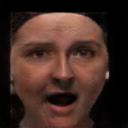

In [80]:
 D.demo(img,target=4)

<a id="5"></a>
## 5. 3DVAEGAN

<a id="5.1"></a>
### 5.1 Training 3DVAEGAN

In [12]:
def train_vae(args):

    hyparam_list = [("model", args.model_name),
                    ("cube", args.cube_len),
                    ("bs", args.batch_size),
                    ("g_lr", args.g_lr),
                    ("d_lr", args.d_lr),
                    ("z", args.z_dis),
                    ("bias", args.bias),
                    ("sl", args.soft_label),]

    hyparam_dict = OrderedDict(((arg, value) for arg, value in hyparam_list))
    log_param = make_hyparam_string(hyparam_dict)
    print(log_param)

    # for using tensorboard
    if args.use_tensorboard:
        import tensorflow as tf

        summary_writer = tf.summary.FileWriter(args.log_dir)

        def inject_summary(summary_writer, tag, value, step):
                summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
                summary_writer.add_summary(summary, global_step=step)

        inject_summary = inject_summary


    # datset define
    dsets_path = args.bos_data_dir
    print(dsets_path)
    dsets = BosphorousDataset(dsets_path, args)
    dset_loaders = torch.utils.data.DataLoader(dsets, batch_size=args.batch_size, shuffle=True, num_workers=0)

    # model define
    D = _D(args)
    G = _G(args)
    E = _E(args)

    D_solver = optim.Adam(D.parameters(), lr=args.d_lr, betas=args.beta)
    G_solver = optim.Adam(G.parameters(), lr=args.g_lr, betas=args.beta)
    E_solver = optim.Adam(E.parameters(), lr=args.e_lr, betas=args.beta)

    if args.lrsh:
        D_scheduler = MultiStepLR(D_solver, milestones=[500, 1000])

    if torch.cuda.is_available():
        print("using cuda")
        D.cuda()
        G.cuda()
        E.cuda()

    criterion = nn.BCELoss()

    pickle_path = args.pickle_dir
    save_new_pickle(path = pickle_path,iteration=1,G=G,G_solver=G_solver, D_= D, D_solver= D_solver)
    read_pickle(pickle_path, G, G_solver, D, D_solver)

    for epoch in tqdm(range(args.max_epoch), total = args.max_epoch, desc ="VAEGAN Training"):
        for i, (image, model_3d) in tqdm(enumerate(dset_loaders)):

            model_3d = var_or_cuda(model_3d)
            image = var_or_cuda(image)
            
            #Ensure Batch size is correct
            if model_3d.size()[0] != int(args.batch_size):
                #print("batch_size != {} drop last incompatible batch".format(int(args.batch_size)))
                continue
            

            Z = generateZ(args)
            z_mu,z_var = E(image)
            Z_vae = E.reparameterize(z_mu,z_var)
            G_vae = G(Z_vae)

            real_labels = var_or_cuda(torch.ones(args.batch_size))
            fake_labels = var_or_cuda(torch.zeros(args.batch_size))

            if args.soft_label:
                real_labels = var_or_cuda(torch.Tensor(args.batch_size).uniform_(0.7, 1.2))
                fake_labels = var_or_cuda(torch.Tensor(args.batch_size).uniform_(0, 0.3))

            # ============= Train the discriminator =============#
            d_real = D(model_3d)
            d_real_loss = criterion(d_real, real_labels)


            fake = G(Z)
            d_fake = D(fake)
            d_fake_loss = criterion(d_fake, fake_labels)

            d_loss = d_real_loss + d_fake_loss

            d_real_acu = torch.ge(d_real.squeeze(), 0.5).float()
            d_fake_acu = torch.le(d_fake.squeeze(), 0.5).float()
            d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))

            if d_total_acu <= args.d_thresh:
                D.zero_grad()
                d_loss.backward()
                D_solver.step()
            else:
                pass
            
            
            # ============= Train the Encoder =============#
            model_3d = model_3d.view(-1, 1, args.cube_len, args.cube_len, args.cube_len)
            recon_loss = torch.sum(torch.pow((G_vae - model_3d),2))
            KLLoss = (- 0.5 * torch.sum( 1 + z_var - torch.pow(z_mu,2) - torch.exp(z_var)))  #/dim1/dim2/dim3)
            E_loss = recon_loss + KLLoss
            E.zero_grad()
            E_loss.backward(retain_graph=True)
            E_solver.step()
            # =============== Train the generator ===============#
            Z = generateZ(args)

            fake = G(Z)
            d_fake = D(fake)
            g_loss = criterion(d_fake, real_labels)
            g_loss += recon_loss
            D.zero_grad()
            G.zero_grad()
            g_loss.backward()
            G_solver.step()

        # =============== logging each iteration ===============#
        iteration = str(G_solver.state_dict()['state'][G_solver.state_dict()['param_groups'][0]['params'][0]]['step'])

        # =============== each epoch save model or save image ===============#
        print('Iter-{}; ,Recon_loss : {:.4} , KLLoss: {:.4}, D_loss : {:.4}, G_loss : {:.4}, D_acu : {:.4}, D_lr : {:.4}'.format(iteration,recon_loss.item(),KLLoss.item() ,d_loss.item(), g_loss.item(), d_total_acu.item(), D_solver.state_dict()['param_groups'][0]["lr"]))
        if (epoch + 1) % args.image_save_step == 0:

            samples = fake.cpu().data[:8].squeeze().numpy()

            image_path = args.image_dir
            if not os.path.exists(image_path):
                os.makedirs(image_path)

            SavePloat_Voxels(samples, image_path, iteration)

        if (epoch + 1) % args.pickle_step == 0:
            pickle_save_path =  args.pickle_dir 
            save_new_pickle(pickle_save_path, iteration, G, G_solver, D, D_solver,E,E_solver)

        if args.lrsh:

            try:

                D_scheduler.step()


            except Exception as e:

                print("fail lr scheduling", e)

In [ ]:
train_vae(args)

model=3DVAEGAN_cube=64_bs=2_g_lr=0.0025_d_lr=0.001_z=norm_bias=False_sl=True
Dataset/Bosphorous/PreProcessed/
using cuda
32736 Checkpoint/3DVAEGAN/Pickle


VAEGAN Training:   0%|                                                                        | 0/3000 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:06,  6.68s/it]
2it [00:10,  5.72s/it]
3it [00:13,  5.06s/it]
4it [00:17,  4.62s/it]
5it [00:20,  4.29s/it]
6it [00:24,  4.06s/it]
7it [00:27,  3.88s/it]
8it [00:31,  3.77s/it]
9it [00:34,  3.69s/it]
10it [00:38,  3.63s/it]
11it [00:41,  3.59s/it]
12it [00:45,  3.57s/it]
13it [00:48,  3.55s/it]
14it [00:52,  3.52s/it]
15it [00:55,  3.50s/it]
16it [00:59,  3.48s/it]
17it [01:02,  3.52s/it]
18it [01:06,  3.50s/it]
19it [01:09,  3.53s/it]
20it [01:13,  3.52s/it]
21it [01:16,  3.53s/it]
22it [01:20,  3.55s/it]
23it [01:23,  3.55s/it]
24it [01:27,  3.53s/it]
25it [01:30,  3.51s/it]
26it [01:34,  3.50s/it]
27it [01:37,  3.49s/it]
28it [01:41,  3.48s/it]
29it [01:44,  3.49s/it]
30it [01:48,  3.50s/it]
31it [01:51,  3.53s/it]
32it [01:52,  2.78s/it]


Iter-32767; ,Recon_loss : 3.021e+04 , KLLoss: 1.811e+03, D_loss : 0.9826, G_loss : 3.022e+04, D_acu : 1.0, D_lr : 0.0001


VAEGAN Training:   0%|                                                            | 1/3000 [01:59<99:26:13, 119.36s/it]
0it [00:00, ?it/s]
1it [00:02,  2.75s/it]
2it [00:06,  3.02s/it]
3it [00:09,  3.16s/it]
4it [00:13,  3.26s/it]
5it [00:16,  3.33s/it]
6it [00:20,  3.38s/it]
7it [00:23,  3.41s/it]
8it [00:27,  3.43s/it]
9it [00:30,  3.46s/it]
10it [00:34,  3.47s/it]
11it [00:37,  3.47s/it]
12it [00:41,  3.48s/it]
13it [00:44,  3.48s/it]
14it [00:48,  3.48s/it]
15it [00:51,  3.47s/it]
16it [00:55,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:02,  3.47s/it]
19it [01:05,  3.46s/it]
20it [01:09,  3.46s/it]
21it [01:12,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:19,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:26,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:33,  3.46s/it]
28it [01:36,  3.47s/it]
29it [01:40,  3.48s/it]
30it [01:43,  3.47s/it]
31it [01:47,  3.47s/it]
32it [01:48,  2.72s/it]


Iter-32798; ,Recon_loss : 2.911e+04 , KLLoss: 1.106e+03, D_loss : 0.9911, G_loss : 2.911e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|                                                            | 2/3000 [03:54<98:14:18, 117.96s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.44s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:57,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:42,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-32829; ,Recon_loss : 2.563e+04 , KLLoss: 633.2, D_loss : 0.8595, G_loss : 2.563e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|                                                            | 3/3000 [05:47<97:03:41, 116.59s/it]
0it [00:00, ?it/s]
1it [00:02,  2.60s/it]
2it [00:06,  2.86s/it]
3it [00:09,  3.04s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.44s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.47s/it]
15it [00:51,  3.47s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.48s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-32860; ,Recon_loss : 2.304e+04 , KLLoss: 785.4, D_loss : 1.215, G_loss : 2.305e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|                                                            | 4/3000 [07:41<96:23:50, 115.83s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-32891; ,Recon_loss : 2.014e+04 , KLLoss: 616.5, D_loss : 0.9709, G_loss : 2.015e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|                                                            | 5/3000 [09:35<95:54:30, 115.28s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-32922; ,Recon_loss : 1.957e+04 , KLLoss: 627.2, D_loss : 0.9051, G_loss : 1.957e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|                                                            | 6/3000 [11:28<95:21:02, 114.65s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:06,  2.91s/it]
3it [00:09,  3.08s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-32953; ,Recon_loss : 1.649e+04 , KLLoss: 563.6, D_loss : 1.318, G_loss : 1.65e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▏                                                           | 7/3000 [13:20<94:38:29, 113.84s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.44s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-32984; ,Recon_loss : 2.683e+04 , KLLoss: 555.0, D_loss : 0.5646, G_loss : 2.684e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▏                                                           | 8/3000 [15:12<94:02:43, 113.16s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33015; ,Recon_loss : 2.47e+04 , KLLoss: 512.7, D_loss : 1.821, G_loss : 2.471e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▏                                                           | 9/3000 [17:04<93:46:10, 112.86s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33046; ,Recon_loss : 1.85e+04 , KLLoss: 726.5, D_loss : 0.3948, G_loss : 1.851e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▏                                                          | 10/3000 [18:57<93:46:57, 112.92s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33077; ,Recon_loss : 2.501e+04 , KLLoss: 763.5, D_loss : 1.889, G_loss : 2.502e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▏                                                          | 11/3000 [20:51<93:56:32, 113.15s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.71s/it]


Iter-33108; ,Recon_loss : 1.534e+04 , KLLoss: 984.0, D_loss : 1.284, G_loss : 1.534e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▏                                                          | 12/3000 [22:45<94:17:05, 113.60s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33139; ,Recon_loss : 2.274e+04 , KLLoss: 846.7, D_loss : 1.173, G_loss : 2.274e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▎                                                          | 13/3000 [24:37<93:42:44, 112.94s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33170; ,Recon_loss : 1.963e+04 , KLLoss: 477.1, D_loss : 1.159, G_loss : 1.963e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▎                                                          | 14/3000 [26:30<93:51:22, 113.16s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33201; ,Recon_loss : 1.649e+04 , KLLoss: 507.2, D_loss : 0.5224, G_loss : 1.65e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   0%|▎                                                          | 15/3000 [28:23<93:49:23, 113.15s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33232; ,Recon_loss : 1.679e+04 , KLLoss: 1.723e+03, D_loss : 1.034, G_loss : 1.679e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▎                                                          | 16/3000 [30:17<93:56:40, 113.34s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33263; ,Recon_loss : 1.549e+04 , KLLoss: 1.152e+03, D_loss : 0.9097, G_loss : 1.549e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▎                                                          | 17/3000 [32:11<94:08:30, 113.61s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.45s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33294; ,Recon_loss : 2.097e+04 , KLLoss: 1.048e+03, D_loss : 0.722, G_loss : 2.097e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▎                                                          | 18/3000 [34:07<94:28:00, 114.04s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33325; ,Recon_loss : 3.19e+04 , KLLoss: 1.737e+03, D_loss : 1.164, G_loss : 3.19e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▎                                                          | 19/3000 [36:00<94:21:36, 113.95s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:06,  2.91s/it]
3it [00:09,  3.08s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33356; ,Recon_loss : 2.483e+04 , KLLoss: 1.147e+03, D_loss : 1.247, G_loss : 2.483e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▍                                                          | 20/3000 [37:53<94:07:29, 113.71s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33387; ,Recon_loss : 1.602e+04 , KLLoss: 605.1, D_loss : 1.837, G_loss : 1.602e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▍                                                          | 21/3000 [39:47<94:04:51, 113.69s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33418; ,Recon_loss : 1.202e+04 , KLLoss: 877.9, D_loss : 1.515, G_loss : 1.202e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▍                                                          | 22/3000 [41:41<94:00:29, 113.64s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33449; ,Recon_loss : 1.861e+04 , KLLoss: 814.4, D_loss : 1.3, G_loss : 1.862e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▍                                                          | 23/3000 [43:35<94:13:38, 113.95s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.46s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.47s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33480; ,Recon_loss : 1.648e+04 , KLLoss: 773.4, D_loss : 1.071, G_loss : 1.649e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▍                                                          | 24/3000 [45:29<94:04:05, 113.79s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:06,  2.91s/it]
3it [00:09,  3.08s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.28s/it]
6it [00:20,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33511; ,Recon_loss : 1.815e+04 , KLLoss: 1.317e+03, D_loss : 0.9222, G_loss : 1.816e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▍                                                          | 25/3000 [47:23<94:15:50, 114.07s/it]
0it [00:00, ?it/s]
1it [00:03,  3.07s/it]
2it [00:06,  3.19s/it]
3it [00:09,  3.27s/it]
4it [00:13,  3.33s/it]
5it [00:16,  3.37s/it]
6it [00:20,  3.40s/it]
7it [00:23,  3.42s/it]
8it [00:27,  3.43s/it]
9it [00:30,  3.44s/it]
10it [00:34,  3.45s/it]
11it [00:37,  3.46s/it]
12it [00:41,  3.46s/it]
13it [00:44,  3.46s/it]
14it [00:48,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:55,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.46s/it]
22it [01:15,  3.47s/it]
23it [01:19,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:26,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:33,  3.47s/it]
28it [01:36,  3.46s/it]
29it [01:40,  3.47s/it]
30it [01:43,  3.46s/it]
31it [01:47,  3.46s/it]
32it [01:48,  2.72s/it]


Iter-33542; ,Recon_loss : 1.481e+04 , KLLoss: 962.4, D_loss : 0.7962, G_loss : 1.482e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                          | 26/3000 [49:19<94:37:55, 114.55s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33573; ,Recon_loss : 1.311e+04 , KLLoss: 1.369e+03, D_loss : 0.8867, G_loss : 1.312e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                          | 27/3000 [51:14<94:47:56, 114.79s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.46s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33604; ,Recon_loss : 1.102e+04 , KLLoss: 1.091e+03, D_loss : 0.828, G_loss : 1.103e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                          | 28/3000 [53:09<94:48:40, 114.85s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.46s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-33635; ,Recon_loss : 1.168e+04 , KLLoss: 1.032e+03, D_loss : 1.178, G_loss : 1.168e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                          | 29/3000 [55:05<94:57:47, 115.07s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33666; ,Recon_loss : 6.893e+03 , KLLoss: 741.5, D_loss : 1.14, G_loss : 6.897e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                          | 30/3000 [57:00<94:48:28, 114.92s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33697; ,Recon_loss : 7.546e+03 , KLLoss: 974.1, D_loss : 0.6058, G_loss : 7.55e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                          | 31/3000 [58:55<94:49:56, 114.99s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.46s/it]
24it [01:22,  3.46s/it]
25it [01:25,  3.46s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.46s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33728; ,Recon_loss : 9.587e+03 , KLLoss: 1.189e+03, D_loss : 1.078, G_loss : 9.592e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▌                                                        | 32/3000 [1:00:49<94:31:55, 114.66s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.06s/it]
4it [00:12,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.31s/it]
7it [00:23,  3.35s/it]
8it [00:26,  3.38s/it]
9it [00:30,  3.40s/it]
10it [00:33,  3.42s/it]
11it [00:37,  3.43s/it]
12it [00:40,  3.44s/it]
13it [00:44,  3.44s/it]
14it [00:47,  3.45s/it]
15it [00:50,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:57,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33759; ,Recon_loss : 1.125e+04 , KLLoss: 1.081e+03, D_loss : 1.006, G_loss : 1.126e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 33/3000 [1:02:43<94:29:30, 114.65s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.38s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.42s/it]
11it [00:37,  3.43s/it]
12it [00:40,  3.44s/it]
13it [00:44,  3.44s/it]
14it [00:47,  3.45s/it]
15it [00:50,  3.45s/it]
16it [00:54,  3.46s/it]
17it [00:57,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:42,  3.46s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33790; ,Recon_loss : 4.777e+03 , KLLoss: 628.0, D_loss : 0.93, G_loss : 4.782e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 34/3000 [1:04:38<94:22:26, 114.55s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33821; ,Recon_loss : 2.178e+03 , KLLoss: 774.3, D_loss : 1.095, G_loss : 2.183e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 35/3000 [1:06:36<95:15:42, 115.66s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.31s/it]
7it [00:23,  3.35s/it]
8it [00:26,  3.38s/it]
9it [00:30,  3.40s/it]
10it [00:33,  3.42s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:57,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:04,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33852; ,Recon_loss : 1.74e+04 , KLLoss: 784.4, D_loss : 0.7694, G_loss : 1.74e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 36/3000 [1:08:32<95:23:26, 115.86s/it]
0it [00:00, ?it/s]
1it [00:02,  2.68s/it]
2it [00:06,  2.91s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.45s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:04,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33883; ,Recon_loss : 1.493e+04 , KLLoss: 1.012e+03, D_loss : 0.8784, G_loss : 1.493e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 37/3000 [1:10:27<95:10:26, 115.63s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33914; ,Recon_loss : 918.6 , KLLoss: 875.7, D_loss : 0.8372, G_loss : 924.2, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 38/3000 [1:12:22<94:57:20, 115.41s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33945; ,Recon_loss : 1.036e+04 , KLLoss: 1.184e+03, D_loss : 0.3224, G_loss : 1.036e+04, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▋                                                        | 39/3000 [1:14:17<94:50:31, 115.31s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-33976; ,Recon_loss : 2.392e+03 , KLLoss: 1.01e+03, D_loss : 1.523, G_loss : 2.395e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▊                                                        | 40/3000 [1:16:12<94:44:35, 115.23s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.46s/it]
21it [01:11,  3.46s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34007; ,Recon_loss : 2.189e+03 , KLLoss: 1.748e+03, D_loss : 1.923, G_loss : 2.192e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▊                                                        | 41/3000 [1:18:09<95:11:26, 115.81s/it]
0it [00:00, ?it/s]
1it [00:02,  2.70s/it]
2it [00:06,  2.93s/it]
3it [00:09,  3.08s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34038; ,Recon_loss : 2.072e+03 , KLLoss: 1.018e+03, D_loss : 1.507, G_loss : 2.076e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▊                                                        | 42/3000 [1:20:06<95:23:54, 116.10s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:04,  3.46s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.46s/it]
31it [01:46,  3.46s/it]
32it [01:47,  2.72s/it]


Iter-34069; ,Recon_loss : 1.632e+03 , KLLoss: 536.0, D_loss : 1.508, G_loss : 1.635e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▊                                                        | 43/3000 [1:22:02<95:13:25, 115.93s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.04s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34100; ,Recon_loss : 187.5 , KLLoss: 629.0, D_loss : 0.2075, G_loss : 190.8, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   1%|▊                                                        | 44/3000 [1:23:57<95:09:05, 115.88s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34131; ,Recon_loss : 743.9 , KLLoss: 446.3, D_loss : 0.4839, G_loss : 747.2, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▊                                                        | 45/3000 [1:25:53<95:07:27, 115.89s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34162; ,Recon_loss : 429.4 , KLLoss: 587.0, D_loss : 1.13, G_loss : 433.3, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▊                                                        | 46/3000 [1:27:49<95:05:45, 115.89s/it]
0it [00:00, ?it/s]
1it [00:02,  2.61s/it]
2it [00:06,  2.86s/it]
3it [00:09,  3.04s/it]
4it [00:12,  3.16s/it]
5it [00:16,  3.25s/it]
6it [00:19,  3.31s/it]
7it [00:23,  3.36s/it]
8it [00:26,  3.39s/it]
9it [00:30,  3.41s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:04,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34193; ,Recon_loss : 104.4 , KLLoss: 656.0, D_loss : 0.8034, G_loss : 107.7, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▉                                                        | 47/3000 [1:29:44<94:48:31, 115.58s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34224; ,Recon_loss : 52.65 , KLLoss: 603.5, D_loss : 1.558, G_loss : 57.09, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▉                                                        | 48/3000 [1:31:39<94:31:40, 115.28s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34255; ,Recon_loss : 48.84 , KLLoss: 879.9, D_loss : 0.7288, G_loss : 53.0, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▉                                                        | 49/3000 [1:33:35<94:44:42, 115.58s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.04s/it]
4it [00:12,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34286; ,Recon_loss : 298.2 , KLLoss: 696.7, D_loss : 1.089, G_loss : 300.4, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▉                                                        | 50/3000 [1:35:30<94:35:05, 115.43s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.46s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34317; ,Recon_loss : 846.5 , KLLoss: 337.0, D_loss : 0.6267, G_loss : 848.9, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▉                                                        | 51/3000 [1:37:24<94:16:57, 115.10s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.91s/it]
3it [00:09,  3.08s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:20,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.46s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34348; ,Recon_loss : 22.06 , KLLoss: 563.5, D_loss : 0.7983, G_loss : 26.26, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|▉                                                        | 52/3000 [1:39:20<94:22:40, 115.25s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34379; ,Recon_loss : 57.77 , KLLoss: 349.3, D_loss : 1.427, G_loss : 60.47, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 53/3000 [1:41:16<94:30:25, 115.45s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34410; ,Recon_loss : 72.21 , KLLoss: 666.3, D_loss : 0.8812, G_loss : 74.98, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 54/3000 [1:43:11<94:29:28, 115.47s/it]
0it [00:00, ?it/s]
1it [00:02,  2.61s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.17s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34441; ,Recon_loss : 105.2 , KLLoss: 167.7, D_loss : 0.5766, G_loss : 107.5, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 55/3000 [1:45:07<94:25:36, 115.43s/it]
0it [00:00, ?it/s]
1it [00:02,  2.72s/it]
2it [00:06,  2.94s/it]
3it [00:09,  3.10s/it]
4it [00:13,  3.21s/it]
5it [00:16,  3.29s/it]
6it [00:20,  3.35s/it]
7it [00:23,  3.38s/it]
8it [00:27,  3.41s/it]
9it [00:30,  3.43s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:19,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34472; ,Recon_loss : 4.37e+03 , KLLoss: 373.4, D_loss : 1.1, G_loss : 4.372e+03, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 56/3000 [1:47:02<94:23:26, 115.42s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.46s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34503; ,Recon_loss : 96.27 , KLLoss: 373.1, D_loss : 1.069, G_loss : 99.1, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 57/3000 [1:48:58<94:23:37, 115.47s/it]
0it [00:00, ?it/s]
1it [00:02,  2.63s/it]
2it [00:06,  2.88s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34534; ,Recon_loss : 52.92 , KLLoss: 575.6, D_loss : 0.6576, G_loss : 55.75, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 58/3000 [1:50:54<94:28:25, 115.60s/it]
0it [00:00, ?it/s]
1it [00:02,  2.65s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34565; ,Recon_loss : 101.1 , KLLoss: 274.6, D_loss : 0.9761, G_loss : 104.2, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█                                                        | 59/3000 [1:52:49<94:24:31, 115.56s/it]
0it [00:00, ?it/s]
1it [00:02,  2.71s/it]
2it [00:06,  2.93s/it]
3it [00:09,  3.09s/it]
4it [00:13,  3.20s/it]
5it [00:16,  3.28s/it]
6it [00:20,  3.34s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.46s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.47s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:19,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34596; ,Recon_loss : 308.7 , KLLoss: 220.0, D_loss : 0.8336, G_loss : 311.0, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█▏                                                       | 60/3000 [1:54:46<94:36:27, 115.85s/it]
0it [00:00, ?it/s]
1it [00:02,  2.62s/it]
2it [00:06,  2.87s/it]
3it [00:09,  3.05s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.26s/it]
6it [00:19,  3.32s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.46s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.46s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34627; ,Recon_loss : 160.7 , KLLoss: 359.7, D_loss : 0.6913, G_loss : 164.0, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█▏                                                       | 61/3000 [1:56:42<94:43:23, 116.03s/it]
0it [00:00, ?it/s]
1it [00:02,  2.64s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.06s/it]
4it [00:13,  3.18s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.44s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.46s/it]
17it [00:58,  3.46s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:11,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34658; ,Recon_loss : 60.56 , KLLoss: 354.8, D_loss : 0.9607, G_loss : 63.3, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█▏                                                       | 62/3000 [1:58:37<94:31:12, 115.82s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.43s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34689; ,Recon_loss : 48.01 , KLLoss: 326.4, D_loss : 0.567, G_loss : 52.32, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█▏                                                       | 63/3000 [2:00:33<94:31:19, 115.86s/it]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:06,  2.89s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34720; ,Recon_loss : 58.06 , KLLoss: 370.4, D_loss : 0.6817, G_loss : 60.71, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█▏                                                       | 64/3000 [2:02:28<94:12:34, 115.52s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:06,  2.91s/it]
3it [00:09,  3.08s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.28s/it]
6it [00:20,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.40s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.44s/it]
11it [00:37,  3.45s/it]
12it [00:40,  3.45s/it]
13it [00:44,  3.46s/it]
14it [00:47,  3.46s/it]
15it [00:51,  3.46s/it]
16it [00:54,  3.47s/it]
17it [00:58,  3.47s/it]
18it [01:01,  3.47s/it]
19it [01:05,  3.47s/it]
20it [01:08,  3.47s/it]
21it [01:12,  3.47s/it]
22it [01:15,  3.47s/it]
23it [01:18,  3.47s/it]
24it [01:22,  3.47s/it]
25it [01:25,  3.47s/it]
26it [01:29,  3.47s/it]
27it [01:32,  3.47s/it]
28it [01:36,  3.47s/it]
29it [01:39,  3.47s/it]
30it [01:43,  3.47s/it]
31it [01:46,  3.47s/it]
32it [01:47,  2.72s/it]


Iter-34751; ,Recon_loss : 15.79 , KLLoss: 213.0, D_loss : 1.543, G_loss : 18.42, D_acu : 1.0, D_lr : 0.001


VAEGAN Training:   2%|█▏                                                       | 65/3000 [2:04:24<94:14:24, 115.59s/it]
0it [00:00, ?it/s]
1it [00:02,  2.67s/it]
2it [00:06,  2.90s/it]
3it [00:09,  3.07s/it]
4it [00:13,  3.19s/it]
5it [00:16,  3.27s/it]
6it [00:19,  3.33s/it]
7it [00:23,  3.37s/it]
8it [00:26,  3.41s/it]
9it [00:30,  3.42s/it]
10it [00:33,  3.46s/it]
11it [00:37,  3.50s/it]
12it [00:41,  3.50s/it]